In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta
plt.rcParams['figure.dpi'] = 144

In [2]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/datadesk/california-coronavirus-data/master/cdph-county-cases-deaths.csv",
    index_col=0,
    parse_dates=[0]
).sort_index()
df = df[df["county"] == "Los Angeles"]
df.index = df.index.tz_localize(tz='US/Pacific')
df['new_cases'] = df.confirmed_cases.diff()
df['new_deaths'] = df.reported_deaths.diff()

In [3]:
positivity = pd.read_csv(
    "https://raw.githubusercontent.com/datadesk/california-coronavirus-data/master/cdph-positive-test-rate.csv",
    index_col=0,
    parse_dates=[0]
).sort_index()
positivity.index = positivity.index.tz_localize(tz='US/Pacific')
positivity = positivity.new_positive_tests / positivity.new_tests
positivity.name = "positivity"
df = df.join(positivity)

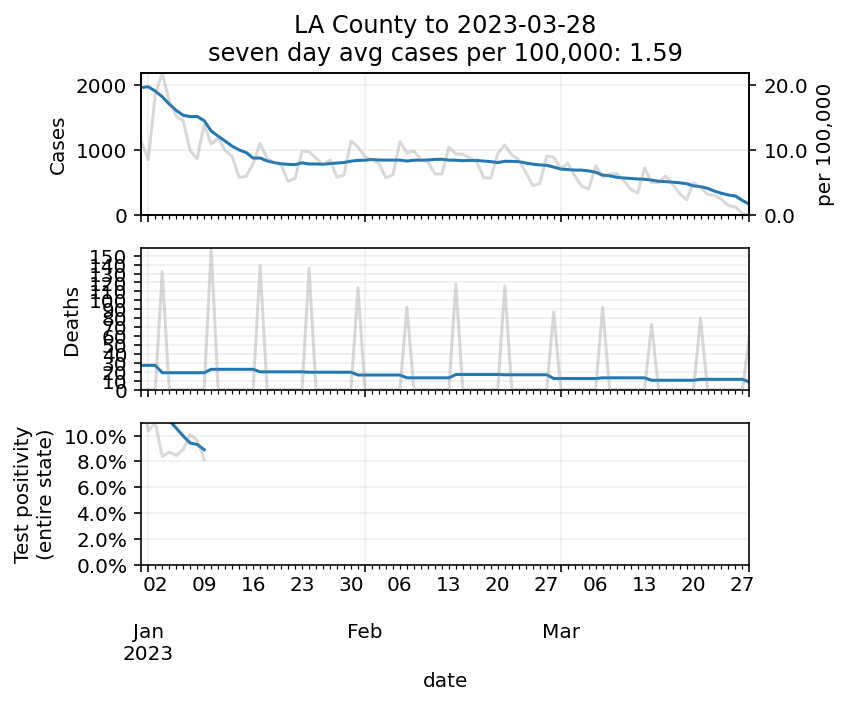

In [4]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(6, 5))

df.new_cases.rolling(window=7).mean().plot(ax=axs[0])
df.new_cases.plot(alpha=0.3, ax=axs[0], color='gray')

df.new_deaths.rolling(window=7).mean().plot(ax=axs[1])
df.new_deaths.plot(alpha=0.3, ax=axs[1], color='gray')

df.positivity.rolling(window=7).mean().plot(ax=axs[2])
df.positivity.plot(alpha=0.3, ax=axs[2], color='gray')

start = datetime.now(tz=timezone.utc) - timedelta(days=90)

axs[0].set_yticks([i*1000 for i in range(100)])
axs[1].set_yticks([i*10 for i in range(100)])
axs[2].set_yticks([i/50 for i in range(100)])
axs[2].set_yticklabels([f"{i*100}%" for i in axs[2].get_yticks()])

axs[0].set_ylim(0, df[start:].new_cases.max())
axs[0].set_xlim(datetime.now(tz=timezone.utc) - timedelta(days=90), None)
axs[1].set_ylim(0, df[start:].new_deaths.max())
axs[2].set_ylim(0, df[start:].positivity.max())

axs[0].set_ylabel("Cases")
axs[1].set_ylabel("Deaths")
axs[2].set_ylabel("Test positivity\n(entire state)")

ax_ = axs[0].twinx()
ax_.set_yticks(axs[0].get_yticks())
ax_.set_yticklabels([i*1000/100 for i in range(100)])
ax_.set_ylim(axs[0].get_ylim())
ax_.set_ylabel("per 100,000")

for a in axs:
    a.grid(alpha=0.2)

title = (
    "LA County to " + df.index[-1].strftime("%Y-%m-%d") 
    + "\nseven day avg cases per 100,000: "
    + str(df.new_cases.rolling(window=7).mean()[-1]/100.)
)
    
axs[0].set_title(title)
fig.tight_layout()
fig.set_facecolor("white")
fig.savefig("lacounty.png", bbox_inches="tight")